Nested runs: https://simonhessner.de/mlflow-optuna-parallel-hyper-parameter-optimization-and-logging/

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import sklearn
import sklearn.compose
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split

from xgboost.sklearn import XGBRegressor

import optuna

import mlflow
from mlflow.tracking import MlflowClient

In [2]:
TRACKING_URI = r"file:.\mlruns"
mlflow.set_tracking_uri(TRACKING_URI)

In [3]:
client = MlflowClient()
EXPERIMENT_NAME = "house_prices_regression"
try:
    experiment = client.create_experiment(EXPERIMENT_NAME)
except:
    experiment = client.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

In [18]:
RUN_NAME = 'XGBoost numeric features hyperparameter optimisation'

In [4]:
class XGBRegressor_FP(XGBRegressor):
    
    def fit(self, *args, **fit_params):
        if fit_params is not None:
            self.set_params(**fit_params)

        return super(XGBRegressor_FP, self).fit(*args) 

In [5]:
df = (
    pd
    .read_csv(
        r'kaggle_data/train.csv',
        index_col='Id'
    )
)

In [6]:
num_cols = [
    c for c in df.drop(columns='SalePrice').columns
    if df.dtypes[c] in ['int64', 'float64']
]

In [7]:
len(num_cols)

36

In [8]:
num_cols

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [9]:
input_cols = num_cols

In [10]:
y = df.pop('SalePrice')
X = df

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
drop_columns_transformer = sklearn.compose.ColumnTransformer(
    [('drop_features', 'passthrough', input_cols)],
    remainder='drop'
)

In [13]:
pipeline = sklearn.pipeline.Pipeline([
    ('drop_features', drop_columns_transformer),
    ('xgb', XGBRegressor_FP()),
])

In [14]:
# Would be nice to put some oop on this maybe?

def get_objective(parent_run_id, experiment):

    def objective(trial):
        trial_run = client.create_run(
            experiment_id=experiment,
            tags={
                'mlflow.parentRunId': parent_run_id
            }
        )

        trial_run_id = trial_run.info.run_id

        params = {
            'xgb__objective': 'reg:squarederror',
            'xgb__eval_metric': 'rmse',
            #'xgb__booster': trial.suggest_categorical('xgb__booster', ['gbtree', 'gblinear', 'dart']),
            'xgb__booster': 'gbtree',
            'xgb__eta': trial.suggest_float('xgb__eta', 0, 1),
            'xgb__gamma': trial.suggest_float('xgb__gamma', 1e-6, 1e6, log=True),
            'xgb__max_depth': trial.suggest_int('xgb__max_depth', 1, 99),
            'xgb__min_child_weight': trial.suggest_int('xgb__min_child_weight', 1, 29),
            'xgb__subsample': trial.suggest_float('xgb__subsample', 0, 1)
        }

        for k, v in params.items():
            client.log_param(trial_run_id, k, v)

        cv_score = cross_val_score(
            pipeline,
            X_train,
            y_train,
            scoring='neg_root_mean_squared_error',
            cv=4,
            n_jobs=-1,
            fit_params=params
        )

        for i, v in enumerate(cv_score):
            client.log_metric(trial_run_id, "cv_test_rmse_{}".format(i), v)

        score = -cv_score.mean()

        client.log_metric(trial_run_id, "neg_mean_test_cv_rmse", score)

        return score

    return objective

In [15]:
study_run = client.create_run(
    experiment_id=experiment,
    tags={
        'mlflow.runName': RUN_NAME
    })
study_run_id = study_run.info.run_id

In [16]:
study = optuna.create_study()

[I 2022-07-01 14:45:39,246] A new study created in memory with name: no-name-723e2e9c-8ecd-48cb-9f6d-ff7c35d71d75


In [17]:
study.optimize(get_objective(study_run_id, experiment), n_trials=10, n_jobs=-1)

C:\Users\Kieran\anaconda3\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-07-01 14:45:45,656] Trial 6 finished with value: 72816.21189258015 and parameters: {'xgb__eta': 0.7393567254074817, 'xgb__gamma': 24432.40517415137, 'xgb__max_depth': 63, 'xgb__min_child_weight': 21, 'xgb__subsample': 0.205357957369512}. Best is trial 6 with value: 72816.21189258015.
[I 2022-07-01 14:45:46,012] Trial 4 finished with value: 63519.26207108339 and parameters: {'xgb__eta': 0.5844177450606766, 'xgb__gamma': 754183.3665003729, 'xgb__max_depth': 77, 'xgb__min_child_weight': 13, 'xgb__subsample': 0.21585523030822296}. Best is trial 4 with value: 63519.26207108339.
[I 2022-07-01 14:45:46,053] Trial 8 finished with value: 42340.41363118334 and parameters: {'xgb__eta': 0.41783798204238354, 'xgb__gamma': 11228.29289002366, 'xgb

In [20]:
fig = optuna.visualization.plot_optimization_history(study)
client.log_figure(study_run_id, fig, "opt_history.html")
fig.show()

In [22]:
fig = optuna.visualization.plot_parallel_coordinate(study)
client.log_figure(study_run_id, fig, "hyperparamter_parallel_coordinates_plot.html")
fig.show()

In [23]:
fig = optuna.visualization.plot_contour(study)
client.log_figure(study_run_id, fig, "hyperparamter_contour_plot.html")
fig.show()

In [24]:
fig = optuna.visualization.plot_slice(study)
client.log_figure(study_run_id, fig, "hyperparamter_slice_plot.html")
fig.show()

In [25]:
fig = optuna.visualization.plot_param_importances(study)
client.log_figure(study_run_id, fig, "hyperparamter_importances_plot.html")
fig.show()

In [26]:
fig = optuna.visualization.plot_param_importances(
    study,
    target=lambda t: t.duration.total_seconds(),
    target_name="duration"
)

client.log_figure(study_run_id, fig, "hyperparamter_duration_importances_plot.html")
fig.show()

In [27]:
fig = optuna.visualization.plot_edf(study)

client.log_figure(study_run_id, fig, "optimization_cdf_plot.html")
fig.show()

In [26]:
study.trials_dataframe()

number          value             datetime_start  \
0        0   60040.056392 2022-06-28 20:41:29.427346   
1        1   36502.742509 2022-06-28 20:41:31.436346   
2        2   36813.952974 2022-06-28 20:41:32.999346   
3        3   60178.236274 2022-06-28 20:41:34.747662   
4        4   47797.633888 2022-06-28 20:41:35.001633   
5        5   64921.877334 2022-06-28 20:41:35.424659   
6        6   36660.806021 2022-06-28 20:41:35.873661   
7        7   33996.880466 2022-06-28 20:41:36.434684   
8        8   51542.377893 2022-06-28 20:41:36.624685   
9        9   31517.846943 2022-06-28 20:41:36.924656   
10      10   33693.380070 2022-06-28 20:41:37.196657   
11      11   33914.725193 2022-06-28 20:41:37.792658   
12      12   32562.264505 2022-06-28 20:41:38.406646   
13      13   33275.026550 2022-06-28 20:41:39.325856   
14      14   33165.287237 2022-06-28 20:41:40.231592   
15      15  113538.957332 2022-06-28 20:41:41.074642   
16      16   32791.291481 2022-06-28 20:41:41.241639   
17      17   76859.572317 2022-06-28 20:41:42.023558   
18      18   36226.990488 2022-06-28 20:41:42.401386   
19      19   35906.086121 2022-06-28 20:41:43.418114   
20      20   29659.441514 2022-06-28 20:41:43.638142   
21      21   29588.290651 2022-06-28 20:41:44.198143   
22      22   29446.762716 2022-06-28 20:41:44.762142   
23      23   29001.422301 2022-06-28 20:41:45.317142   
24      24  196748.769799 2022-06-28 20:41:45.833142   
25      25   29764.261775 2022-06-28 20:41:46.182316   
26      26   28959.196354 2022-06-28 20:41:46.714317   
27      27   28844.103626 2022-06-28 20:41:47.194327   
28      28   29458.468966 2022-06-28 20:41:47.630326   
29      29   32466.894376 2022-06-28 20:41:48.051326   
30      30   35829.317030 2022-06-28 20:41:48.501326   
31      31   29062.895037 2022-06-28 20:41:49.082325   
32      32   30957.260427 2022-06-28 20:41:49.565628   
33      33   28724.814893 2022-06-28 20:41:50.085628   
34      34  173053.105201 2022-06-28 20:41:50.542069   
35      35   30183.575918 2022-06-28 20:41:50.876962   
36      36   40701.857370 2022-06-28 20:41:51.451181   
37      37   30378.383224 2022-06-28 20:41:51.976641   
38      38   29063.915468 2022-06-28 20:41:52.500438   
39      39   36454.086338 2022-06-28 20:41:52.906175   

            datetime_complete               duration  params_xgb__eta  \
0  2022-06-28 20:41:31.376345 0 days 00:00:01.948999         0.350400   
1  2022-06-28 20:41:32.937346 0 days 00:00:01.501000         0.222060   
2  2022-06-28 20:41:34.688594 0 days 00:00:01.689248         0.521268   
3  2022-06-28 20:41:34.945667 0 days 00:00:00.198005         0.647199   
4  2022-06-28 20:41:35.367658 0 days 00:00:00.366025         0.621764   
5  2022-06-28 20:41:35.811659 0 days 00:00:00.387000         0.858141   
6  2022-06-28 20:41:36.377685 0 days 00:00:00.504024         0.502993   
7  2022-06-28 20:41:36.568683 0 days 00:00:00.133999         0.114167   
8  2022-06-28 20:41:36.860657 0 days 00:00:00.235972         0.624336   
9  2022-06-28 20:41:37.139655 0 days 00:00:00.214999         0.163567   
10 2022-06-28 20:41:37.731657 0 days 00:00:00.535000         0.035186   
11 2022-06-28 20:41:38.349646 0 days 00:00:00.556988         0.033338   
12 2022-06-28 20:41:39.268855 0 days 00:00:00.862209         0.257279   
13 2022-06-28 20:41:40.174592 0 days 00:00:00.848736         0.289145   
14 2022-06-28 20:41:41.017637 0 days 00:00:00.786045         0.199225   
15 2022-06-28 20:41:41.183638 0 days 00:00:00.108996         0.375821   
16 2022-06-28 20:41:41.966636 0 days 00:00:00.724997         0.164574   
17 2022-06-28 20:41:42.339669 0 days 00:00:00.316111         0.995376   
18 2022-06-28 20:41:43.350115 0 days 00:00:00.948729         0.413929   
19 2022-06-28 20:41:43.572141 0 days 00:00:00.154027         0.272978   
20 2022-06-28 20:41:44.136141 0 days 00:00:00.497999         0.111460   
21 2022-06-28 20:41:44.701143 0 days 00:00:00.503000         0.103816   
22 2022-06-28 20:41:45.24514

In [28]:
best_params = study.best_params

In [29]:
best_params

{'xgb__eta': 0.13805755862012759,
 'xgb__gamma': 0.10220153137921127,
 'xgb__max_depth': 61,
 'xgb__min_child_weight': 9,
 'xgb__subsample': 0.944618329266938}

In [30]:
final_pipe = pipeline.fit(X_train, y_train, **best_params)

In [31]:
best_xgb = final_pipe[-1]

In [32]:
feature_importances = (
    pd
    .Series(best_xgb.feature_importances_)
    .set_axis(input_cols)
)

In [33]:
import matplotlib.pyplot as plt

<ipython-input-35-7c535b10dfa1>:15: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



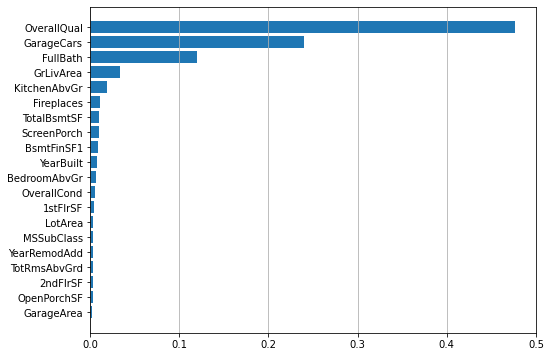

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))

sorted_fi = (
    feature_importances
    .sort_values()
    .iloc[-20:]
)

ax.barh(sorted_fi.index, sorted_fi.values)
ax.grid(axis='x')


client.log_figure(study_run_id, fig, "feature_importances.png")

fig.show()

In [36]:
best_y_pred = final_pipe.predict(df)

<ipython-input-37-963cf7445421>:17: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



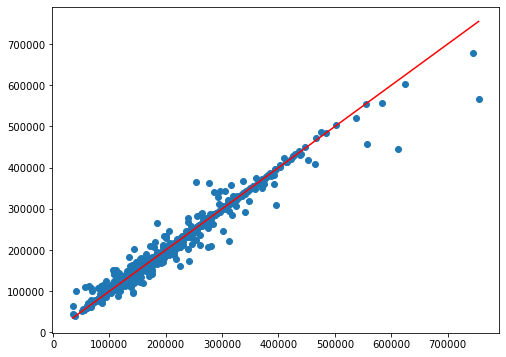

In [37]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(y, best_y_pred)

min_y_in = min(y)
max_y_in = max(y)
min_y_pred = min(best_y_pred)
max_y_pred = max(best_y_pred)

min_y = min(min_y_in, min_y_pred)
max_y = max(max_y_in, max_y_pred)

ax.plot([min_y, max_y],[min_y, max_y], color='red')

client.log_figure(study_run_id, fig, "base_pred_scatter_plot.png")

fig.show()

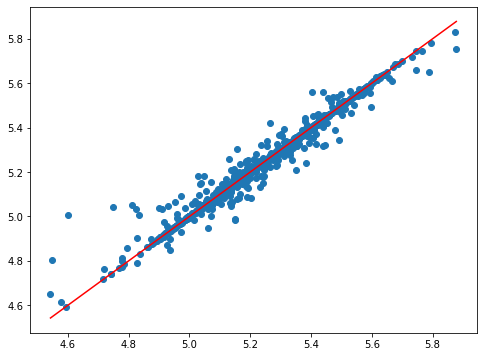

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(np.log10(y), np.log10(best_y_pred))

min_y_in = min(y)
max_y_in = max(y)
min_y_pred = min(best_y_pred)
max_y_pred = max(best_y_pred)

min_y = min(min_y_in, min_y_pred)
max_y = max(max_y_in, max_y_pred)

client.log_figure(study_run_id, fig, "base_pred_log10_scatter_plot.png")

ax.plot([np.log10(min_y), np.log10(max_y)],[np.log10(min_y), np.log10(max_y)], color='red')

To-do: Look at shaply values.
Cache early steps of pipeline.
Try out catboost.
MLFlow.

In [39]:
import shap

In [40]:
explainer = shap.explainers.Tree(best_xgb, feature_names=input_cols)

In [41]:
preproc_X_train = final_pipe[:-1].transform(X_train)

In [42]:
shap_values = explainer.shap_values(preproc_X_train, y_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


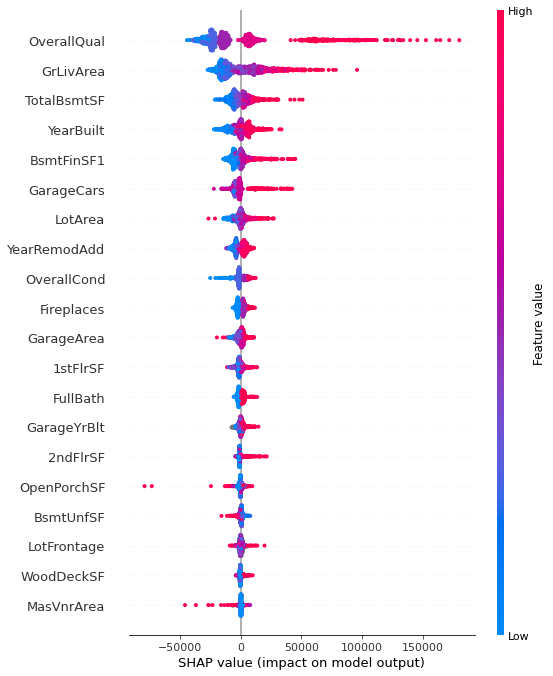

In [47]:
shap.summary_plot(
    shap_values,
    preproc_X_train,
    feature_names=input_cols,
    show=False
)

fig = plt.gcf()

client.log_figure(study_run_id, fig, "shap_summary_plot.png")

fig.show()

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


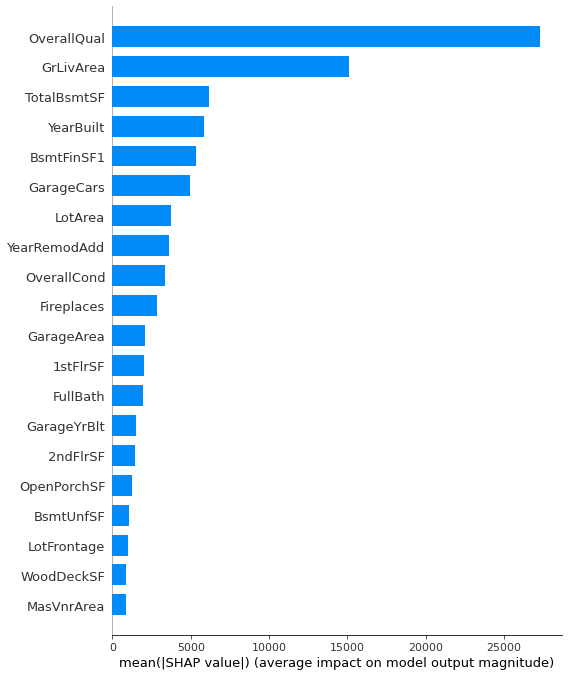

In [48]:
shap.summary_plot(
    shap_values,
    preproc_X_train,
    feature_names=input_cols,
    show=False,
    plot_type='bar'
)

fig = plt.gcf()

client.log_figure(study_run_id, fig, "shap_bar_summary_plot.png")

fig.show()

In [49]:
qual_index = next(i for i, v in enumerate(input_cols) if v == 'OverallQual')
qual_index

3

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


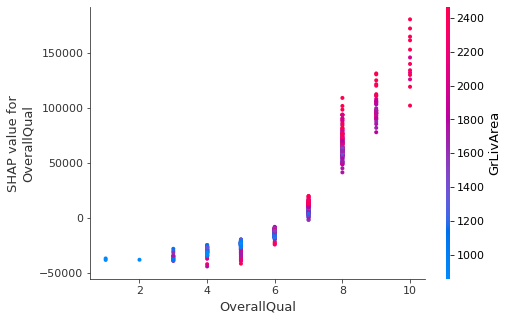

In [51]:
shap.dependence_plot(
    qual_index,
    shap_values,
    preproc_X_train,
    feature_names=input_cols,
    show=False
)

fig = plt.gcf()

client.log_figure(study_run_id, fig, "overall_quality_shap_dependency_plot.png")

fig.show()

In [45]:
shap.plots.initjs()

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


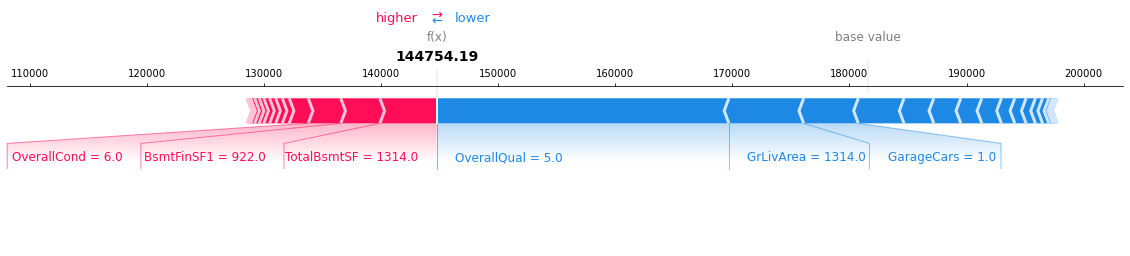

In [54]:
n = 0

fig = shap.force_plot(
    explainer.expected_value,
    shap_values[n,:],
    preproc_X_train[n,:],
    feature_names=input_cols,
    show=False,
    matplotlib=True
)

fig = plt.gcf()

client.log_figure(study_run_id, fig, "0_shap_force_plot.png")

fig.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


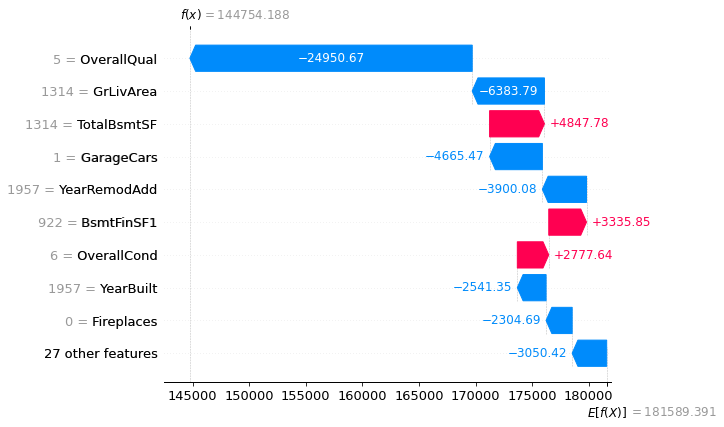

In [55]:
shap.plots.waterfall(explainer(preproc_X_train)[0], show=False)

fig = plt.gcf()

client.log_figure(study_run_id, fig, "0_shap_waterfall_plot.png")

fig.show()

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


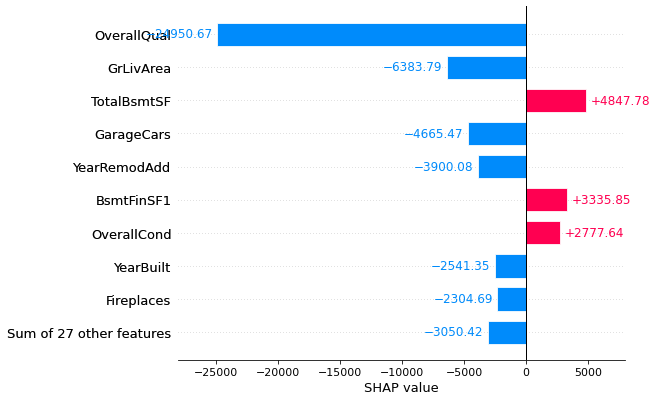

In [56]:
shap.plots.bar(explainer(preproc_X_train)[0], show=False)

fig = plt.gcf()

client.log_figure(study_run_id, fig, "0_shap_diverging_bar_plot.png")

fig.show()

In [50]:
#shap.plots.force(explainer(preproc_X_train), feature_names=input_cols)

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


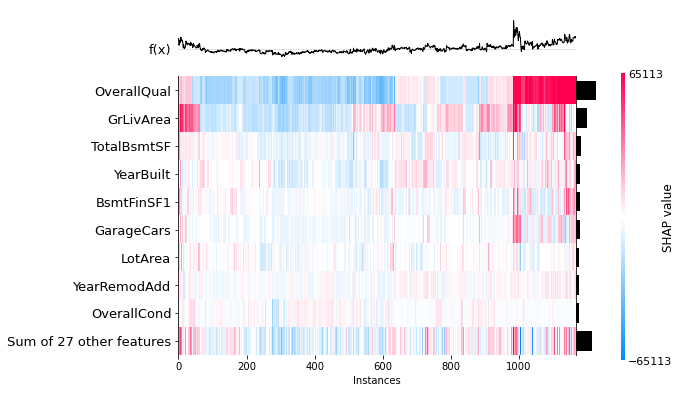

In [57]:
shap.plots.heatmap(explainer(preproc_X_train), show=False)

fig = plt.gcf()

client.log_figure(study_run_id, fig, "shap_heatmap_plot.png")

fig.show()

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


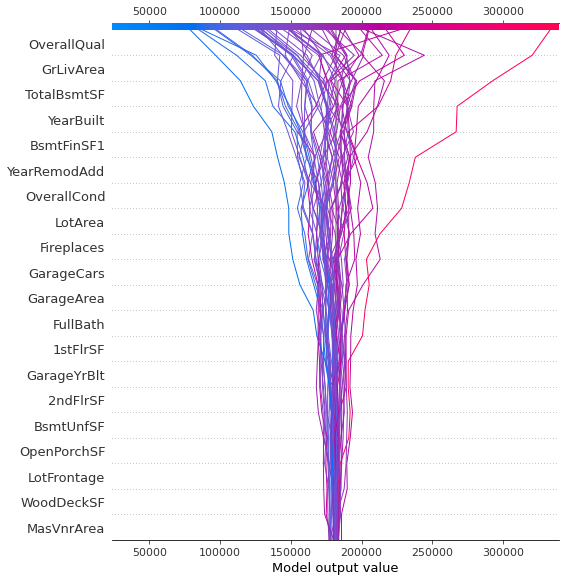

In [58]:
shap.decision_plot(
    explainer.expected_value,
    shap_values[:50,:],
    preproc_X_train[:50,:],
    feature_names=input_cols,
    show=False
)

fig = plt.gcf()

client.log_figure(study_run_id, fig, "shap_decision_plot.png")

fig.show()

* Fix cross validation test sets